In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<Axes: xlabel='median_house_value', ylabel='Count'>

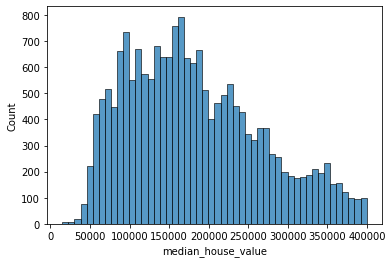

In [4]:
sns.histplot(df.median_house_value[df.median_house_value < 400000], bins=50)


<Axes: xlabel='median_house_value', ylabel='Count'>

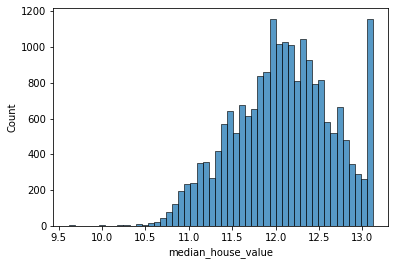

In [5]:
price_logs = np.log1p(df.median_house_value)
sns.histplot(price_logs, bins =50)

In [6]:
df_base=df[(df['ocean_proximity']=='<1H OCEAN') | (df['ocean_proximity']=='INLAND')]
del df_base['ocean_proximity']
df_base = df_base.reset_index(drop=True)

In [7]:
df_base.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
3,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
4,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


### Question 1

In [8]:
df_base.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2

In [9]:
df_base.population.describe()

count    15687.000000
mean      1466.317205
std       1180.389908
min          3.000000
25%        802.000000
50%       1195.000000
75%       1777.000000
max      35682.000000
Name: population, dtype: float64

In [10]:
df_base.population.median()

1195.0

In [11]:
n = len(df_base)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [12]:
n

15687

In [13]:
n_val, n_test, n_train

(3137, 3137, 9413)

In [14]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [15]:
df_train = df_base.iloc[idx[:n_train]]
df_val = df_base.iloc[idx[n_train:n_train+n_val]]
df_test = df_base.iloc[idx[n_train+n_val:]]

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [18]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

### Question 3

In [19]:
def prepare_X(df, rep=0):
    df_num = df
    df_num = df_num.fillna(rep)
    X = df_num.values
    return X

In [20]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [21]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

#### Q3 with fill with 0

In [22]:
X_train = prepare_X(df_train, rep=0)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, rep=0)
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),2)

0.34

#### Q3 with fill with mean (only train)

In [23]:
mean_total_bedrooms=df_train['total_bedrooms'].mean()
mean_total_bedrooms


542.552956325786

In [24]:
X_train = prepare_X(df_train, rep=mean_total_bedrooms)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, rep=mean_total_bedrooms)
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),2)

0.34

### Question 4

In [25]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [26]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = round(rmse(y_val, y_pred),2)
    
    print(r, score)

0 0.34
1e-06 0.34
0.0001 0.34
0.001 0.34
0.01 0.34
0.1 0.34
1 0.34
5 0.35
10 0.35


### Question 5

In [27]:
scores=[]

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df_base.iloc[idx[:n_train]]
    df_val = df_base.iloc[idx[n_train:n_train+n_val]]
    df_test = df_base.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']


    X_train = prepare_X(df_train, rep=0)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, rep=0)
    y_pred = w0 + X_val.dot(w)
    score =rmse(y_val, y_pred)
    scores.append(score)
    
    

In [28]:
scores

[0.33773871601002586,
 0.3377999353662383,
 0.33842870067782543,
 0.3320049468304091,
 0.3394451862554302,
 0.34338197052850067,
 0.33853302117696743,
 0.34687476972828396,
 0.3512736865961087,
 0.33415582665166776]

In [29]:
round(np.std(scores),3)

0.005

### Question 6

In [30]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df_base.iloc[idx[:n_train]]
df_val = df_base.iloc[idx[n_train:n_train+n_val]]
df_test = df_base.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [31]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

In [32]:
X_full_train = prepare_X(df_full_train)
y_full_train = np.concatenate([y_train, y_val])

In [33]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [34]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
round(score,2)

0.33